--- 
Project for the course in Microeconometrics | Summer 2021, M.Sc. Economics, Bonn University | [Philipp Schreiber](https://github.com/pcschreiber1)

# Replication of Henderson, Storeygard, Deichmann (2017) :
## Has climate change driven urbanization in Africa? <a class="tocSkip">   
    
    
---

<div class="alert alert-block alert-info">
    <h5><b>Downloading and viewing this notebook:</b></h5> <p> The original paper, as well as the data and code provided by the authors can be accessed <a href="https://doi.org/10.1016/j.jdeveco.2016.09.001">here</a> </p></div>

## Content:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import statsmodels.formula.api as smf
import seaborn as sns

#For spatial analysis
import geopandas as gpd
import shapely.geometry as geom
import libpysal as lp #For spatial weights

from pysal.viz import splot #exploratory analysis
from pysal.explore import esda #exploratory analysis
from pysal.model import spreg #For spatial regression

pd.options.display.float_format = "{:,.2f}".format

In [2]:
from auxiliary.data_import import *
from auxiliary.plots import *
from auxiliary.simulations import *
from auxiliary.tables import *

---
# 1. Introduction 
---

In this paper Henderson et al. investigate the impact of increasing aridity on urbanization in Sub-Saharan Africa. In particular, the authors address the questions of i) *whether adverse changes in climate induce a push from rural to urban areas* and ii) *how this within-country migration affects incomes in cities*.  They attribute previous studies' mixed findings to aggregation effects resulting from using national level data and, therefore, use variation at the district and city level. To enable such an analysis the authors constructed a panel data set combining district level census data, fine resolution climate data and **night time lights (NTLs)** between 1960 and 2008. The authors' central finding is that climate shocks only produce rural-urban movements if cities are can offer alternative employment options. 

The analysis is framed by a simple model of rural-urban migration where the migration decision depends on potential wages in the rural and urban sectors, respectively. It follows that rising aridity (i.e., a decline in moisture) only draws citizens into the urban sector in the presence of a manufacturing base creating potentially tradeable goods. Otherwise, the urban sector only services the rural sector and there is no competition for labour. The study employs country-level **two-way fixed effects (2FE) regression** to generate reduced form estimates of the net effect of moisture on urbanization growth and city incomes. Importantly, the authors also provide two robustness checks for the underlying causal mechanism (i.e., aridity driving incomes): i) drawing on the Social Conflict Analysis Database, they do not find evidence of conflict driving the results and ii) at the city level, the effect of conflict on incomes is ambiguous, which does not match the data observed. In the face of the dire climate change projections we are confronted with today, the policy insight from this paper is simple: successful spatial and structural adaptation to climate change will critically depend on the capacities of cities. 

In this notebook, I replicate the core results presented in the paper by Henderson et al. (2017). In addition, I enrich the author’s analysis by a detailed discussion of the underlying identification strategy under the counterfactual framework. Importantly, I show that the Stable Unit Treatment Value Assumption (SUTVA) is violated through spatial interdependence and, in turn, **introduce a spatially explicit identification and estimate its results**. My analysis offers general support for the findings of Henderson et al. and provide an exploratory use case of a spatially explicit counterfactual model.

The remaining notebook is then structured as follows. In the next section, I discuss the literature on climate induced migration, emphasising the interdisciplinarity of the subject (Section 2). Section 3 then introduces the data set as well as the use of NTLs. The analysis is then structured around the two identification strategies. In Section 4, I first discuss the 2FE identification strategy used by the authors and then proceed to reproduce the core results. The final part of Section 4 discusses the robustness checks of the underlying causal mechanism. Section 5 develops the spatially explicit analysis. After explaining the tension between SUTVA and ignorability I use the results from a simulation study to illustrate the feasible identification strategies. I then examine the spatial dependence present in the data and estimate a set of spatial models. Section 6 offers concluding remarks. 

<span style="color:orange">**NOTE**:</span> While the structure of the discussion deviates from that of the original paper, all figures and tables with replication results follow the original numbering.


---
# 2. Theoretical Background
---

The question of the climate change on people's decision where to live has drawn attention from a variety of disciplines and academic traditions. Naturally, there is not a unique answer to such a complex socio-politico-economic-ecological phenomenon as migration. Jónsson (2010)identifies two general conceptual approaches to studying climate-migration patterns: Push-Pull factor and Multi-level Contextual driver approaches. **While Henderson et al. (2017) explicitly position themselves in the former tradition we will see below that their disaggregated analysis can be seen to bridge the gap between the two traditions**.

As the authors point out, the present study is most closely tied to the 2006 paper by Barrios et al., who use change in raifall to estimate the effect of adverse climate change on urbanization. Motivated by the concept of climate refugess, the authors posit that a generally low degree of arrigation makes the Sub-Saharan agricultural sector particularly vulnerable to rainfall shocks. Similarly, Brückner (2012) uses rainfall as an instrument for agricultural GDP and also find that a decrease in rainfall increases urbanization growth. Both studies also ascribe themselves to the Push-Pull factor framework. In contrast, the literature on Multi-level contextual drivers - mostly developed by anthropoligists and political scientists - sees the connection between climate change and  migration as a lot less clear. In particular, they emphasise the multiplicity of strategies citizens have at hand when facing climate shocks. **What is more, as Morrissey (2009) points out, it could be argued that climate change in the Sahel region because it undermines migration**, due to lack of resources. The feasibility and attractivness of migration then also critically depends on the presence of social networks. An alternative line of investigation points towards the political ecology - that is, the subjectivity of interpretation of climate change - which threatens both the externality and usefulness of ecological climate measures.

The sub-national analysis of Henderson et al. (2017) enables a significantly more nuanced perspective of migration. The emphasis on labour market arbitrage is an important step in better reflecting parts of the complexity that individuals face.

<h3><u>2.2 A labour market model of rural-urban migration</u></h3>

The authors model districts as small open economies which are differentiated by the presence of manufacturing facilities for potentially tradeable goods.  In this context, a decline in moisture should only induce local migration in industrialized districts, since in exclusievly rural districts cities are only provide agriculture with services that not traded across districts, the local agricultural sector is not competing for labor.

More precisely, the economies face fixed prices of imports and exports and are divided into a rural and an urban sector. Both produce services but the latter also may or may not produce tradeable goods. In line with standard urban models, workers living in the city face diseconomies of scale due to commuting costs to generate a stable equilibrium. Migration arbitrage etween the urban and rural sectors equalizes incomes and there is full employment. An adverse climate shock then decreases wages in the rural. Service incomes in the urban sector would also decline, however, since urban wages equalize, the wage effect is ambigous: if there is no or only a neglible manufacturing sector, city incomes also decrease and there is no migration arbitrage. But **if there is a significant manufacturing sector, the urban wages will decrease less, generating the opporunity for migration arbitrage**. In the real world, the presence of industry is endogenous of course. This issue is addressed again in the identification section. The authors fully describe the model in Appendix B, for further information on urban economic models, refer to Duranton and Puga (2004) and Desmet and Henderson (2015).

---
# 3. Data
---

I now proceed to discuss the measures of urbanization, income, climate data and industrialization that the authors use. While high-quality climate data is readily available at all levels of resolution, the same is not true for demographic and economic data. Still, if available, the large increase in the number of observations can be a strong benefit to the analysis. At the district level, the data set contains census data between 1960 to 2008 and includes 369 districts or 29 countries. The city level analysis spans from 1992 to 2008 and includes 1158 cities and towns in 42 countries.
<h3><u>3.1 Urbanization</u></h3>

Most studies employ **population data** from infrequent national census reports and rely heavily on imputations and interpolations. To avoid this, the study includes countries with at least two available censuses with the relevant information for a complete or nearly complete set of sub-national units, where either district boundaries changed little or common units over time can be defined. The authors digitized data from hardcopy census publications. Of the 32 available countries, Namibia, Congo-Brazzaville and Liberia were dropped due to issues of district definition or census frequency. The 29 remaining countries count between 2 to 5 censuses between 1960 and 2019. For estimation purposes Kenya is treated as two countries before and after the urban redefinition of the 1990s. While extensive, the sample omits several Sub-Saharan countries, most notably Nigeria, the most populous country on the continent. These countries were omitted either because the censuses lacked the required information or printed volumes were unavailable. South Africa was excluded because of Post-Apartheid migration. The district panel is unbalanced and the authors calculate the annualised urban growth as the difference in urban population averaged by length of the intercensal period. Districts vary a lot in size, a topic which is analysed more closely in section 5.

In contrast, high quality **climate data** is much more readily available at the district level. To reflect climatic agricultural potential the authors use precipitation over potential evapotranspiration (PET) (i.e. system supply over system demand) as a moisture index. The precipitation and temperature data is available from the University of Delaware gridded climate data set while PET is estimated using the Thornthwaite method. The district level climate indicator is then the average grid cell value that overlaps with the corresponding sub-national unit where cells that cross the boundary are weighted.

Sub-national **data on industrialization** is scarce in many census reports - before 1985 this is even true for national level indicators. Henderson et al. draw on the *Oxford Regional Economic Atlas, Africa* (Ady, 1965) which maps all industries by type and city location, based on an in-depth analysis from a variety of sources from the late 1950s and early 1960s. From the total 26 industries the authors exclude 10 agricultural processing industries (e.g. brewing, milling) and use the count of different industries as the industrialization indicator. Comparing this index to 2000 IPSUM data on manufacturing, the 1960 industry count still functions as a good proxy. The full 26 industries are used in most robustness checks. Since the value is not updated, it can be interpreted as the likelihood of having industry at time $t$.

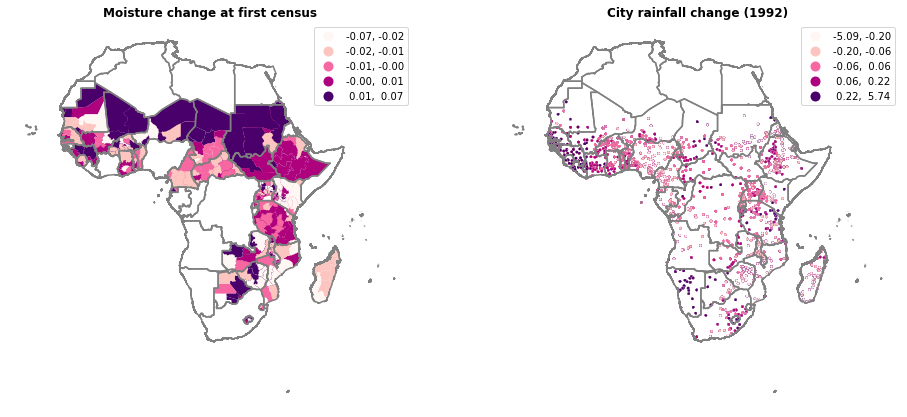

In [3]:
districts, coast = get_shapefile()
_, citydata = get_spatialdata()
map_data_section(districts, coast, citydata)

<h3><u>3.2 Income</u></h3>

Due to the lack of consistently available **data on total city income**, **night time lights (NTLs)** are used as a proxy. NTLs have become a well-established proxy for economic activity at sub-national levels, a comprehensive overview is provided in Donaldson and Storeygard (2016). The relationship between economic growth and NTLs was first formally tested in Henderson et al. (2012) who found a linear relationship between lights and GDP, a result which was later corroborated by Hodler and Raschky (2014). In the present study, the authors use annual average data from 1992 to 2008 using data from the U.S. Defense Meteorological Satellite Program (DMSP). As is typical in socioeconomic analyses, clouds and rainfall are excluded and only stable light sources are included. City income is then mapped as the sum of the light intensity of every pixel in the outer envelope. 

Now, since traditional **climate indicators** such as the moisture index are not available at such fine resolutions, rainfall is used instead. The data is used from the Rainfall Climatology Version 2, which combines weather station data with satellite information. Each city's hinterland annual average rainfall is then the average of grid-cell values within 30km of the ever-lit area. Since the moisture index split the sample almost evenly, the authors "calculate average near-city rainfall between 1983 (the first year in the data) and 1991, and split at the sample median".

Lastly, for **industrialization** data, the modern and total industry indicators from the 1965 Oxford Regional Economic Atlas are used. As mentioned above, the 2000 IPSUM data on manufacturing validates the indicator as a good proxy for industrialization at later. Still, for robusteness checks

The scarcity of local indicators also is also one of the driving forces for the 2FE specification to account for the unobservables. I now turn to the discussion of Henderson et al.'s (2017) underlying identification strategy. Still, the national agricultural share in GDP for 1989-1991 is used for robusteness checks.

---
# 4. Identification
--- 

As already touched upon above, the low level of aggregation provides both challenges and opportunities. In the case of identification, the fine resolution gives us the opportunity to exploit micro-level mechanisms. On the other hand, the scarcity of data implies that we must rely on a few key variables. While new data sources are being developed and operationalized, as we will see in Section 5, careful consideration of the possibilities and limits of identification is only becoming more relevant. Note, the analyses of the effect of adverse climate change on urban growth and city income are clsoely linked and draw on the same model of rural-urban migration. That is why the identification is disucussed for both approaches together.

From the simple model of rural-urban migration, we can then deduce the following causal graph:
<img src="material/Basic_DAG_2.PNG" alt="Should display: Basic_DAG_2"  title="Basic DAG" width="300"/>

<h3><u>4.1 Fixed Effecs</u></h3>

Armed with only two explanatory variables from the model of rural-urban migration – the annual level of moisture and the 1960s development of industry – the authors set out to analyse the effect of adverse changes in climate on within-district migration. However, the authors exploit several strategies to account for unobservables: firstly, they propose a **growth-specification** which removes district-specific time-invariant effects such as soil quality, centrality, etc. Secondly, the authors combine this with a **country-level 2FE** specification, which accounts for national-time varying conditions driving urban growth, such as definition of urban areas. The proposed baseline specification can be summarised as:

$Urb_{ijt} = \beta_0 Moist_{ijt} + \beta_1 Indust_{ij} + \beta_2 Indust_{ij} \times Moist_{ijt} + \beta_4 Control_{ij} + \alpha_{jt} + \varepsilon_{ijt}$

where subscripts define district $i$, country $j$ and year $t$. $Urb_{ijt}$ is the annualized growth of the urban population share, $Moist_{ijt}$ is the 3 year smoothed moisture growth and $Indust_{ij}$ is the time-invariant 1960s level of industrialization, interpreted as the likelihood of a district having industry. $Control_{ij}$ includes the two variables distance to coast and initial urban share. Finally, $\alpha_{jt}$ is the country-time fixed effects and $\varepsilon_{ijt}$ is the errors clustered by district.

In the social science literature, the two-way fixed effects (2FE) regression is an extremely popular tool for accounting for both unit-specific (but time-invariant) and time-specific (but unit-invariant) *unobserved* confounders in a flexible manner. However, as Imai and Kim (2019) illustrate, their application requires careful consideration of the identification assumptions: besides the assumption of additivity and seperability of the unobserved variables, it also critically relies on the linearity of their effects. In addition, Imai and Kim explain that, contrary to popular belief, the 2FE generally fails to be equivalent to the explicitly causal difference-in-difference (DiD) estimator. The requirements of fixed effects are illustrated by a causal graph:

<img src="material/2FE_DAG_1.PNG" alt="Error: 2FE_DAG_1" style="width: 700;"/>


From the directed acyclical graph (DAG) we can immediately see that the identifying assumptions of unit fixed effects and time fixed effects are the same, except that one allows the unobservables to be unit-specific (but time-invariant) and the other time-specific (but unit-invariant) - is indicated by the different subscripts. Note also that in both graphs there is no effect of unobservables on the treatment. This is because climate shocks can be reasonably believed to be exogenous, in a sense it is a pseudo-instrument of migration decisions. However, it is not a real instrument because it is not taking the place of another variable but itself the variable we are interested in. Due to the limitations of the data, this exogeneity of the treatment is one of the biggest strengths of the analysis: regardless of the presence of unobservables, as visualized by the DAGs, these cannot create a back-door path! **As a result, the strength of the treatment indicator can compensate for a lot of the doubts we might have with regards to the validity of the fixed effects**. Still, 2FEs will be important for reducing the signal-to-noise ratio. In addition, for estimating the true effect of the presence of industry (and its relationship with moisture) the 2FEs become crucial again.

Extending the rationale for the first differencing, the **country fixed effects** will account for such innante national characteristics. Two examples could be the general presence of social networks between citizens as well as the cultural relevance of migratory strategies. Similarly, the authors suggested that complementing this with **time fixed effects** address issues such as urban re-definition. However, we might easily believe that this does not account for some of the key drivers of industrial development, such as sub-national policies. In relation to the present identification, this would seem to force the assumption that the local industrial development was linear and only influenced by local constants and global pushes. Yet, as the reader might remember, our industy variable does not vary over time! In a way, it is another instrumental variable: the likelihood of having industry at time $t$ based on industrial development in the 1960s. What this means is that we only need to believe that the 1960s level is independent of unobservables also influencing today's growth rates. This sets the bar a lot lower for the fixed effects.

<span style="color:green">**Tying this back**, </span>Henderson et al. (2017) draw on two quasi-instruments in their analysis: climate shocks and 1960s level of industrialisation. Because we might be less confident in the exogeneity of the level of industrialisation than that of climate effects, the 2FEs must cover potential back-door paths of this variable. While we might generally think that fixed effects are not very convincing for such a complex issue as industrial development, unobservables with legacy effects which continue to influence urban growth today might be more easily be covered. In our case, potential candidates would be effects from colonialism, culture or regional relations.

<h3><u>4.2 Climate change and urbanization</u></h3>

We now proceed to replicate and discuss the empirical estimates of Henderson et al. (2017). **Table 2** reports the central results of the effect of moisture on urbanization and **corroborates the hypothesis that the effect of a decline in moisture is ambigous**.  

In [4]:
# ----------------------------------------------------------
# ----------------   Table 2   -----------------------------
# ----------------------------------------------------------
regiondata = pd.read_stata("data/regiondata.dta")
#define order of display
regressors = ["ADsm0_2moistu",
              "extent_agE_ADsm0_2moistu",
              "extent_agH_ADsm0_2moistu",
              "extent_agE",
              "extent_agH",
              "firsturbfrac",
              "lndiscst"]

specification = {"2.1 - No industry": 
                      ["ADsm0_2moistu",
                       "firsturbfrac",
                       "lndiscst"],
                 "2.2 - Modern industry": 
                      ["ADsm0_2moistu",
                       "extent_agE",
                       "extent_agE_ADsm0_2moistu",
                       "firsturbfrac",
                       "lndiscst"],
                 "2.3 - Total Industry": 
                      ["ADsm0_2moistu",
                       "extent_agH",
                       "extent_agH_ADsm0_2moistu",
                       "firsturbfrac",
                       "lndiscst"]}

#filtering out outliers
regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")
#convert selected variables to permille
regiondata.loc[:, ["extent_agE", "extent_agH","firsturbfrac", "lndiscst"]] = regiondata.loc[:, ["extent_agE", "extent_agH","firsturbfrac", "lndiscst"]] /1000

get_table_regiondata(regressors, specification, regiondata)

The first specification estimates the effect of moisture on urbanization while neglecting any heterogeneity in the likelihood of having industry. While the coefficient is negative, it is not statistically significant. A negative and 
statistically significant effect only arises when we control for the heterogeneity in industry. Column 2 includes the indicator *(9 - number of modern industries)*, where 9 is the maximum count observed. As explained in Section 3, modern industries exclude agricultural industries such as milling. Both the change in moisture and the interaction effect are now strongly statistically significant. The specification of industry likelihood allows us to interpret the moisture coefficient as the effect of moisture for the most industrialized: **a one standard deviation decrease in the growth rate of moisture increases the growth rate of the urban share by about 1.5 percent**. Column 3, using the total industry indicator, presents a similarly strong point estimate for the most industrialized districts.

The paper pursues **a variety of robusteness checks** to further explore the effect of moisture. In all of these the total industry indicator is used. Three dynamics of interest are i) whether the industry measure is capturing general effects of distance to the coast, ii) whether the neighbours decline in moisture is relevant, iii) if the effect is sensitive to the measure of aridity.

In [5]:
# ----------------------------------------------------------
# ----------------   Table 3   -----------------------------
# ----------------------------------------------------------
regiondata = pd.read_stata("data/regiondata.dta")

regressors, specification = get_district_robustness_specification()

#filtering out outliers
regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")
#convert selected variables to permille
permille_vars = ["extent_agE",
                 "extent_agH",
                 "firsturbfrac",
                 "lndiscst",
                 "ADsm0_2moistulndiscst"]
regiondata.loc[:, permille_vars] = regiondata.loc[:, permille_vars] /1000

get_table_regiondata(regressors, specification, regiondata)

In Columns 1 and 2 of **Table 3** we find that both the effect of log-distance to coast and its moisture interaction are statistically insignificant. Neither do they seem to drive the effect of moisture, since in Column 1 the estimate is extremely similar to the result from Table 2. And once the industry-moisture interaction is dropped, the effect of moisture is again statistically not significant. 

While this paper – in the line with the literature – focuses on within-district migration, there is the potential that migrants might also move across districts.  For that reason, the authors identified for each district one neighbour and include both its growth in moisture as well as it’s interaction effects. In Column 3, both coefficients are close to zero and statistically insignificant – the estimated effect of moisture remains unchanged again. However, this hypothesis merits closer attention since such spill-over effects can violate SUTVA. That is why we’ll return to this topic again in Section 5, where we’ll see that the choice of neighbour is not innocent and there are indeed spatial effects.

Since temperature data is not available at the city level, the analysis of city incomes has to rely on precipitation (rainfall) as its moisture measure. Hence, comparing the behaviour of the two indices is key.  Column 4 replaces the moisture index with the precipitation measure. **We find that the coefficients on precipitation and its interaction with industry are extremely similar to the results for the PET moisture index from Table 2, which strengthens our confidence in the city level analysis.** However, when we also include temperature, the other component of the PET indicator, we see that is dominates the moisture effect. The coefficients related to precipitation cease to be statistically significant and instead we have a statistically significant and strongly positive effect of temperature.



Finally, since most of the existing literature is based on country-level analyses, the authors also estimate **cross-country results**. Besides repeating the baseline specification and analysising the sensitivity to the choice of moisture indicator an the national level, we also examine the effect on primacy (the share of the largest city in national population). The reason for this is that the theoretical model addresses within-district migration, which might be a poor reflection of the larger national patterns. Given that on the continent, primate cities dominate the urban landscape, we could expect that adverse climate shocks induce migration to the capital.

In [6]:
# ----------------------------------------------------------
# ----------------   Table 5   -----------------------------
# ----------------------------------------------------------
countrydata = pd.read_stata("data/countrydata.dta")
# specifying order of display
regressors = ["ADsm0_2moistu",
              "sum_agH_ADmoistu",
              "ADsm0_2preu",
              "sum_agH_ADpreu",
              "sum_agH",
              "sum_agH_primwide",
              "sum_agH_primwide_ADmoistu",
              "sum_agH_nonprimwide",
              "sum_agH_nonprimwide_ADmoistu"]

specification = {"5.1 - No industry": 
                      ["ADsm0_2moistu"],
                 "5.2 - No interaction": 
                      ["ADsm0_2moistu",
                       "sum_agH_ADmoistu",
                       "sum_agH"],
                 "5.3 - Precipation": 
                      ["ADsm0_2preu"],
                 "5.4 - Precipitation with Industry": 
                      ["ADsm0_2preu",
                       "sum_agH",
                       "sum_agH_ADpreu"],
                 "5.5 - Growth of captial city": 
                      ["ADsm0_2moistu",
                       "sum_agH_primwide",
                       "sum_agH_primwide_ADmoistu",
                       "sum_agH_nonprimwide",
                       "sum_agH_nonprimwide_ADmoistu"]}


#convert selected variables to permille
permille_vars = [_ for _ in regressors if _ not in (
                                            "ADsm0_2moistu","ADsm0_2preu"
                                                    )]
countrydata.loc[:, permille_vars] = countrydata.loc[:, permille_vars] /1000

get_table_countrydata(regressors, specification, countrydata)

Like the share of urban population, the explanatory variables have been adapted to the national-level analysis. In particular, the total industry indicator takes the form (72 - number of cities * number of industries), where 72 is the maximum count observed in the sample. For the growth in the primate city, the indicator reads (25 - number of cities * number of industries in the primate) and (47 - number of cities * number of industries not in the primate) - all three variables are set to permille.

The first two columns of **Table 5** correspond to the baseline specifications in Table 2. While the result is similar in the sense that, on its own, moisture does not have a significant effect, accounting for heterogeneity in industry does not change this. In fact, **for all cross-country specifications, all coefficients fail standard significance tests**. Replacing PET moisture the frequently used precipitation, we see that - while statistically not significant - the estimates are again very close. This presents a disconnect to the previous studies of Barrios et al. (2006) and Brückner (2012), introduced in Section 2, who found significant effects of moisture at the national level. Henderson et al. suggest two reasons for this: one the one hand, Barrios et al. and Brückner used a larger sample which might make the two results not comparable. On the other hand, **in contrast to the present study, these analyses heavily rely on population estimates, which might also partially explain this difference in findings**.

Finally, when analysing the effect on a primate city growth, all coefficients fail to be significant, again. The estimated moisture effect, albeit negative, is also very small. A notable feature of this regression is the dual inclusion of industry indicators reflecting the likelihood of industry in the primate and in the rest of the country. While the coefficients are not significant, the signs are still interesting: in line with our theory, the presence of industry outside of the primate city adversely affects primate city growth. But as can be expected, the two coefficients are high correlated (correlation coefficient of 0.67, see below) - a problem which is only exacerbated in the interation with moisture.

In [7]:
corr = countrydata["sum_agH_nonprimwide"].corr(countrydata["sum_agH_primwide"])
corr2 = countrydata["sum_agH_nonprimwide_ADmoistu"].corr(countrydata["sum_agH_primwide_ADmoistu"])
print(f"The correlation between primate and non-primate industry is {corr: .2f}, and\n{corr2:.2f} for the interaction terms.")

The correlation between primate and non-primate industry is  0.67, and
0.94 for the interaction terms.


**Because of this strong multi-collinearity I estimate an additional specification** which only includes the industry level of the primate. However, as can be seen in the table below - the coefficients continue to be statistically insignificant. In fact, even though the variance of the variables related to industry decreases slightly, the variance of the moisture effect nearly doubles.

In [8]:
regressors = ["ADsm0_2moistu",
              "sum_agH_primwide",
              "sum_agH_primwide_ADmoistu"]

specification = {"Only primate industry": 
                      ["ADsm0_2moistu",
                       "sum_agH_primwide",
                       "sum_agH_primwide_ADmoistu"]}

get_table_countrydata(regressors, specification, countrydata)

This analysis of the underlying mechanism brings us to the final part of Henderson et al. (2017). I emphasise again that even though the authors call the city level analysis a robustness check of the underlying mechanism, they dedicate separate chapters to examining city incomes and the relevance of conflict. For the sake of clarity, these two discussions are combined here.

<span style="color:orange">**NOTE**:</span>  In Column 5 of Table 5, in the original paper the coefficient on the interaction effect of moisture and industry reads 0.0154 rather than 15.4. The reason for that is that, contrary to the notation, the authors failed to transform the variable to permille. The replication sticks with the intended transformation to permille.

<h3><u>4.3 Causal Mechanisms</u></h3>

Returning to the issues of Section 2, migration is a very complex social process. While the previous section provided evidence for the existence of an effect of moisture mediated by the presence of industry, the relevance of industry might not necessarily be causal. This issue is addressed by the present subsection. **First the authors test a hypothesis which would be difficult to reconcile with other theories** - namely a positive effect of decreasing moisture on city incomes. **Secondly, the authors explicitly test the relevance of conflict mechanisms**, using the Social Conflict Analysis Databse (SCAD). The approaches are discussed in turn.

<h3 style="color:SlateGray;">Climate change and city income</h3>

Returning to the basic model of within-district migration, the presence of tradeable manufacturing goods was a necessary condition for the existence of rural-urban labour market competition. From this theory, **if local towns perform an exportable activity, an adverse moisture shock unambigously raises city outputs**. For competing theories such as conflict-based explanations, the relationship between displacement and city income is a lot less clear. Hence, finding this effect in the data should increase our confidence that the mechanism we specified is really what is driving the results.

To re-iterate from section 3, Night Time Lights (NTLs), the proxy for city output, are only available from 1992 onwards. Hence, the window of analysis is shorter, but we have observations for every year. Similarly, the number of countries increased to 42. Since the underlying theoretical model remains the same, the base specification reads:
$ln(light_{it}) = \beta_{j} \sum^{k}_{j=0} \beta_{j} ln(rain_{i,t-j})+ \sum^{k}_{j=0}\gamma_{j}X_{j}' ln(rain_{i,t-j})+\lambda_{t} + \alpha_{i}t + \varepsilon_{it}$

where subscript $i$ denotes a city and $t$ indicates the  year. The variables are again first differenced to create a growth specification. The notation of $\sum^{k}_{j=0} \beta_{j} ln(rain_{i,t-j})$ emphasises that different leads and lags can be included. $light_{it}$ is then the growth in light intensity and  $rain_{i,t-j}$ is the average daily rainfall of a given year. $X_{i}$ refers to time-invariant city-level indicators for moisture and industrial propensity and  $\lambda_{t}$ and $\alpha_{i}$ year and city fixed effects. Finally, $\varepsilon_{it}$ are again clustered errors.

The authors justify the 2FE specification by a need to account for i) annual differences in sensor settings and ii) time invariant city conditions. In particular, the latter term also accounts for a linear, city-specific growth path. Potential unobservables which the specification does not account for are again political varibales: industrial policies might perhaps be random between the more than 11.000 cities, but political stability - as discussed next - should be expected to develop dynamically with climatic conditions.


The following analysis closely mirrors the one at the district level. Table 6 emulates Table 2 in that it examines the effect of rainfall with and without accounting for heterogeneity in industry. As mentioned in Section 3, the values from Ady (1965) remain good proxies of likelihood of industry for the years of 1992 and, hence, continue to be used. Table 7 then proceeds to estimate several robusteness checks. Broadly speaking, **the findings corroborate the district-level results in that, conditional on the presence of industry, adverse precipitation shocks increase city income**.

In [9]:
# ----------------------------------------------------------
# ----------------   Table 6   -----------------------------
# ----------------------------------------------------------
citydata = pd.read_stata("data/citydata.dta")
# specifying order of display
regressors = ["dlnrain30",
              "extent_agE_dlnrain",
              "extent_agH_dlnrain",
              "D_ag30_dlnrain"]

specification = {"6.1 - No industry": 
                      ["dlnrain30"],
                 "6.2 - Modern industry": 
                      ["dlnrain30",
                       "extent_agE_dlnrain"],
                 "6.3 - Total industry": 
                      ["dlnrain30",
                       "extent_agH_dlnrain"],
                 "6.4 - Share of agriculture": 
                      ["dlnrain30",
                       "D_ag30_dlnrain"]}

get_table_citydata(regressors, specification, citydata)

Column 1 of Table 6 estimates the average effect of a decrease in rainfall on city output. While a small negative effect is detected, it fails any standard significant tests. Like on the district level, this changes once we include industry regressors - see Columns 2 and 3. Importantly, we again observe the dynamic that the effect of moisture becomes smaller, the less industrialized the city. While the coefficients for moisture and its interaction effects decreased, we must remember that we are both working at a different level of aggregation and a different independent variable. Considering the coefficients from Column 3, for the most industrialized city a percentage change in rainfaill growth increases NTLs by -17%. Applying the lights-GDP elasticity of about 0.3 from Henderson et al. (2012) this implies a 5% increase in GDP for a one percent decrease in rainfall (or an elasticity of -0.05). In Column 4, as an alternative to the 1965 measurement of industry, the authors introduce a national-level industry indicator. 
Here, likelihood of having industry is based on the national share of agriculture. The effect of moisture and the interaction effect continue to be strongly statistically significant. The coefficient decreases a little, so that for the most industrialized countries, we estimate an elasticity of city NTLs to rainfall of -0.08. However, for less industrialized countries, the effect of moisture on NTLs is positive.

Table 7 then proceeds to investigate the robustness of the above results. The precipiation estimator is provides a less accurate measurement of moisture, hence, the first robustness check looks for heterogenous effect depending on the backlands general aridity. Subsequently, two lag and lead specifications are analysed.

In [10]:
# ----------------------------------------------------------
# ----------------   Table 7   -----------------------------
# ----------------------------------------------------------
citydata = pd.read_stata("data/citydata.dta")
# specifying order of display
regressors = ["dlnrain30",
              "extent_agH_dlnrain",
              "hirain_dlnrain",
              "hirain_extent_agH_dlnrain",
              "Ldlnrain30",
              "Lextent_agH_dlnrain",
              "Fdlnrain30",
              "Fextent_agH_dlnrain"]

specification = {"7.1 - Regional aridity without industry": 
                      ["dlnrain30",
                       "hirain_dlnrain"],
                 "7.2 - Regional aridity with industry": 
                      ["dlnrain30",
                       "extent_agH_dlnrain",
                       "hirain_dlnrain",
                       "hirain_extent_agH_dlnrain"],
                 "7.3 - Lagged effect of rainfall": 
                      ["dlnrain30",
                       "extent_agH_dlnrain",
                       "Ldlnrain30",
                       "Lextent_agH_dlnrain"],
                 "7.4 - Lead effect of rainfall": 
                      ["dlnrain30",
                       "extent_agH_dlnrain",
                       "Fdlnrain30",
                       "Fextent_agH_dlnrain"]}

get_table_citydata(regressors, specification, citydata)

While the model of rural-urban migration might be ambigous on the effect of the general level of aridity,the authors suggest that an area's aridity might exacerbate the effetcs. The literature is similarly divided on this topic: while drier regions will be better adapted, as De Brujin and Van Dijk (2003) argue, mobility might play a more central role in their livelihood strategies. In the first column, we find that both moisture and area aridity coefficients are statistically significant and suggest that drier areas we can indeed expect a stronger effect of climate shocks. However, in Column 2 we see that also including industry regressors eliminates the significance of the area aridity. The industry coefficient is also only weakly significant while the effect of rainfall shocks remains similar to Table 6. Potential area effects are not investigated further.

The remaining two columns include lag and lead effects respectively. The reader might remember that at the district level, the PET moisture average was smoothed - the reason for this being that it is persistent changes in climate that are expected to induce migration decisions. Now that we have annual data, the timing of events might become more relevant. Column 3 proposes that citizens base their decision on last and the current years rainfall. The coefficients fail to be statistically significant. Column 4 specifies a scenario where decisions might be based on a forecast. While this time the coefficients of this year's rainfall are strongly statistically significant and mirror the results from Table 6 in magnitude, the coefficients of the lead effect are not significant.

<span style="color:green">**In summary**, </span>**our first analysis of the causal mechanism supports the hypothesis that labour market decisions drive the migration patterns we observe**. Alternative explanations such as the climate-conflict nexus are very ambigous with regards to the effect on city incomes. As shown in Table 6, we only observe a significant average effect of precipitation if we control for likelihood of industry. However, since researchers carefully constructed disaggregated conflict databases, we now proceed to also explicitly analyse the impact of conflict in our present sample.

<h3 style="color:SlateGray;">Climate change and conflict</h3>

As explained in Section 2, one of the most prominent areas of research in understanding the impact of climate change on migration is dedicated to the analysis of conflict. This emphasis of socio-political channels to migration is not incompatible with labour market based approaches, however, it might cast doubt on the results of the existing analysis. In the following analysis, the SCAD conflict data is used at the city level for a two-fold reason: on the one hand, the fact that SCAD data is only available between 1990 and 2013 simply better matches the NTLs. On the other hand, since many of the SCAD conflicts are very much local in nature, the sometimes extraordinary district size might render aggregation inappropriate.

Since conflict might have varied and inconsistent effects on economic activity, the interpretation of the results is less causal and more focused on identifying drivers of the results.

In [11]:
# ----------------------------------------------------------
# ----------------   Table 8   -----------------------------
# ----------------------------------------------------------
citydata = pd.read_stata("data/citydata.dta")

# For the sake of legibility, the regression specification has been placed in the auxiliary file
regressors, specification = get_conflict_specification()

#convert selected variables to permille
permille_vars = regressors[2:]
citydata.loc[:, permille_vars] = citydata.loc[:, permille_vars] /1000

get_table_citydata(regressors, specification, citydata)

For comparison, Column 1 re-runs the total industry specification of Table 6. Now, the second column adds three measures of conflict pertaining to whether a conflict occurred within 3km or 50km of the city, or whether it occurred at the national level. While the effect of national-level conflict is statistically significant, the coefficients of moisture and its interaction with industry remain unchanged. Column 3 then adds iteractions between conflict and industry, however, these also remain insignificant and do not alter the coefficients on moisture and moisture-industry. Column 4 then includes all remaining interactions: the coefficients on moisture and its interaction with industry slightly increase in magnitude while the coefficient on close-by conflict turns significant. All other coefficients remain insignificant. Lastly, Column 5 reiterates Column 4 but lags all conflict variables by one period. The effects closely mirror the previous models.

This tells us that **the results of the labour market model specification are not masking the effect of conflicts**. Not only are almost all conflict coefficients statistically insignificant, both the magnitude and significance of the moisture and industry terms remained robust to their inclusion. This is the final check of the underlying causal mechanism and brings the analysis of the original paper to an end. However, as already pointed-out during the previous sections, there remains potential for investigating the interdependence of the  observations. **This extension of the original paper is the goal of the follwing final section**.

<span style="color:orange">**NOTE**:</span> While the paper also discusses micro-evidence from DHS surveys in India, no information is provided concerning precisely which surveys or methods were used and the authors were unresponsive to any inquiries.

---
# 5. Spatial Explicit Counterfactual analysis
---

These are probably the most pressing difficulties. However, while not explicitly discussed in the paper, there are two mitigating strategies the authors chose. Firstly, in particular with regards to heterogeneity from local migration policies, the authors filtered-out countries with prominent policies, such South Africa. Secondly, due to the large sample size an argument can be made that the potential bias from local policies is averaged out in the sample.

However, there is another identification challenge which is only recently receiving increased attention: independence of observed units. Spatial dependence and it's implications for SUTVA are discussed now.

<h3><u>5.1 Spatial Identification (Extension)</u></h3>

For a valid estimation of the treatment effect, the potential outcome model relies on the assumption of Stable Unit Treamtent Variance (**SUTVA**). Albeit there exist different formulations, SUTVA essentially requires that i) *there are no different versions of treatment* and ii) *that units not be affected by the treatment status of other units* (Rubin, 1986). This second condition means that **the presence of spill-over and general equilibrium effects needs to be ruled out by the researcher** (see Cunnigham, 2021). To illustrate this in the context of Henderson et al., consider the DAG below: the causal processes of two units are not connected.

<img src="material/Spatial_DAG_colour_2.PNG" alt="Error: Should Display spatial DAG colour 1" title="DAG fulfilling SUTVA" width="600"/>

However, as already hinted at above, in many cases we might find this assumption of no spill-overs hard to defend. Indeed, Tobler's first law of geography asserts that "everything interacts with everything, but two nearby objects are more likely to do so than two distant objects". These spatial effects are frequently divided into **spatial dependency** (autocorrelation, spill-overs, etc.) and **spatial non-stationarity** (heterogeneity of effects), but the distinction is not always clear-cut and the two can interact (for more, see Anselin, 1988).

A common strategy for maintaining SUTVA is spatially aggregating data (see Imbens and Rubin 2015; Morgan and Winship 2014). While popular, it is evident that this "non-strategy" directly undermines the added-value of disaggregated data. Translating this to the present study, the issue is whether districts can really be believed to be independent open economies. While the authors admit that there is considerable cross-country variability, they argue that on average districts are "large. But as can be seen from the histogram below, the distribution is indeed very skewed - with few enormous districts strongly inflating the average. Indeed, more than half of the districts are smaller than $12.000 \:km^2$, which roughly corresponds to the size of Northern Ireland or Montenegro. This, however, significantly undermines the plausibility of "no-spillover effects". 

The median size of districts in the sample is  11,666km


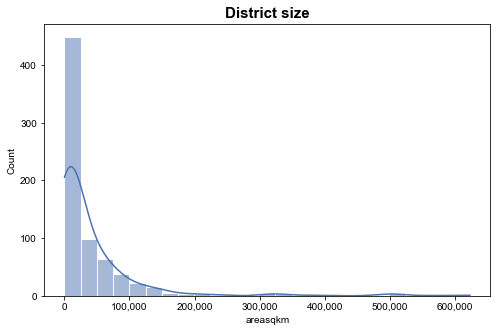

In [13]:
#------------------------------------------------------
#---  Analysing district sizes   ----------------------
#------------------------------------------------------
median = int(regiondata[["iso3v10", "province", "areasqkm"]].median()[0])
print(f"The median size of districts in the sample is {median: ,}km")

n_bins = 25

fig, ax = plt.subplots(figsize=(8, 5))
sns.set_theme(style='whitegrid')
ax.set_title("District size", fontweight="bold", fontsize=15)
g = sns.histplot(ax=ax, x=regiondata['areasqkm'], bins=n_bins, kde=True)
g.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

As Kolak and Anselin (2019) point out, this highlights a more fundamental problem - in many disaggregated, spatially-motivated analyses, *SUTVA is incompatible with the dynamics of interest*, namely the interplay of disaggregated communities. For that reason, Kolak and Anselin seek to set the foundation of a **spatially explicit counterfactual framework**, arguing that an "explicitly spatial perspective of the counterfactual framework considers spatial effects in the structure of the research design and assesses their influence on assignment and on the final treatment effect evaluation" (p.130). And while they provide few practical guidelines, the authors explain that this "also requires controlling for violations of the assumption of independence between observations and outcomes, in combination with spatial effects, that is, SD (spillover effects) and SH (different responses in different contexts)" (p.130). Here Castner et al.'s (2014) insight that, in disaggregated data, there exists a "fundamental trade-off between SUTVA and ignorability" (p.9) reveals at least one possible entry point for making the counterfactual spatial: **breaking down the distinction between SUTVA and ignorability**. Rather than clinging to the SUTVA assumption, the interaction effects need to be carefully examined as part of the identification procedure. Importantly, just like in the traditional case, our believed specification will determine what kind of questions we can ask with the data available.


**However, what does this mean in practice?** A convenient solution would be if simply extending the maxim of "blocking all back-door paths" to cross-unit relations. But, as we will see below, **only controlling for back-door paths is not sufficient**. Still, using a simulation study we will see that, if we can model the true relationship, we will be able to exploit the spatial structure to render identification feasible.

<img src="material/Spatial_DAG_subgraphs.PNG" alt="Error: Should Display spatial DAG subgraphs" title="DAG subgraphs" style="width: 800;"/>

Before we can proceed to the simulation, we first we need to better understand the potential patterns of interdependence. The above four DAGs each illustrate a model where SUTVA is violated due to spillovers. We discuss each in turn. In the simplest case (a) one unit's treamtent directly affects the other unit's output. In this model, which in spatial economerics is referred to as SLX, there is **no back-door path** since $D_1$ and $D_2$ are independent of each other. Case b) represents a szenario where the outputs directly affect each other, i.e. there exists a spatial lag. Since the outcome is naturally observed and a descendant of the treatment, there is again no back-door path. 

The remaining two DAGs are more interesting. Formally speaking, DAG c), formally known as a Spatial Durbin Model (SDM), does not have a back-door path. This is because $D_1$ and $D_2$ continue to be exogenous. However, as will be demonstrated by the simulation, not accounting for this loop will cause a non-spatial estimate to over- or underestimate the effect of treatment - depending on the effect of $D_i$ on $Y_j$. Now, in Case d) $D_1 - D_2 - M_2 - Y_2 - Y_1$ represents a classical back-door path. As we will see in the simulation, while there is no loop like in model c), for estimating the causal effect the backd-door path will need to be blocked.

In order to understand whether in the present study we can exploit the structure of spatial dependence to make identification feasible, we first need to better grasp the spatial patterns which are present in the data.

<h3><u>5.2 Spatial simulation study (Extension)</u></h3>

In the above discussion we pointed out, that three of the four specifications of spatial dependence correspond to standard spatial econometric models. In what follows, we will run a simulation study for each of the DAG's and see whether non-spatial estimates can recover the true ATE. For the sake of simplicity, the specified DGPs are abstracted from the DGP in the in the rural-urban model. In particular, i) the treatment is binary, ii) the treatment has a positive impact on the dependent variable, iii) the interaction between the controls and treatment are left out. Note, that while simpler, this still allows us to represent all of the hypothesised mechanisms. The parametric specification of the four Data Generation Processes (DGPs) is as follows  

 - SLX specification: $Y = WD\gamma +  X \beta + u $ where $W$ is the weight matrix and $\gamma=0.25$, $\beta = 0.5$
 
 - Spatial Lag specification: $Y = WY \rho +   D\gamma +  X \beta + u $ where $W$ is the weight matrix and $\gamma=0.25$, $\beta = 0.5$, $\rho = 0.05$.
 
 - SDM specification: $Y = WY \rho +   WD\gamma +  X \beta + u $ where $W$ is the weight matrix and $\gamma=0.25$, $\beta = 0.5$, $\rho = 0.05$.
 
 - Backdoor specification: $Y = WY \rho +  D\gamma +  X \beta + u $ and $D = WD$ where $W$ is the weight matrix and $\gamma=0.25$, $\beta = 0.5$, $\rho = 0.05$.

We compare true ATE, non-spatial estimate and spatial estimate for three different sample sizes:
   - Simple: One simulation with $n=100$
   - Small: $100$ simulations with $n=100$
   - Large: $100$ simulations with $n=2.500$ (for SLX $100$ simulations with $n=10.000$)
   
For the simulation study the true weight matrix is assumed to be known and given by the 10 nearest neighbours.

<span style="color:orange">**NOTE**:</span> Since the simulations are computationally very expensive, they have been placed in a seperate notebook.

In [14]:
get_simulation_results()

SLX Simulation             Spatial Lag             SDM Simulation  \
                    Simple Small Large      Simple Small Large         Simple   
ATE                   0.25  0.25  0.25        0.25  0.25  0.25           0.25   
Non-spatial           0.55  0.24  0.25        0.27  0.26  0.26           0.36   
spatial               0.25  0.25  0.25        0.25  0.25  0.25           0.25   

                        Backdoor Simulation              
            Small Large              Simple Small Large  
ATE          0.25  0.25                0.25  0.25  0.25  
Non-spatial  0.34  0.41                0.30  0.41  0.41  
spatial      0.25  0.25                0.25  0.25  0.25